# Train

## Split train-validation-test

In [20]:
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])
from utils import *

In [21]:
import pandas as pd

In [22]:
train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

In [23]:
df = pd.read_csv("../csv/filtered_audio.csv")

In [24]:
#Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
good_df = df[df['tango_decision'] == "GOOD"]
bad_df = df[df['tango_decision'] == "BAD"]

In [26]:
train_idx = int(train_ratio*len(bad_df))
valid_idx = train_idx + int(valid_ratio*len(bad_df))

train_bad_df = bad_df[:train_idx]
valid_bad_df = bad_df[train_idx:valid_idx]
test_bad_df = bad_df[valid_idx:]

In [27]:
train_idx = int(train_ratio*len(good_df))
valid_idx = train_idx + int(valid_ratio*len(good_df))

train_good_df = good_df[:train_idx]
valid_good_df = good_df[train_idx:valid_idx]
test_good_df = good_df[valid_idx:]

In [28]:
train_df = pd.concat([train_bad_df, train_good_df])
valid_df = pd.concat([valid_bad_df, valid_good_df])
test_df = pd.concat([test_bad_df, test_good_df])

In [29]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
valid_df = valid_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [30]:
train_df.to_csv("../csv/train.csv", index=False)
valid_df.to_csv("../csv/valid.csv", index=False)
test_df.to_csv("../csv/test.csv", index=False)

## VGG-CatBoost train

In [31]:
%matplotlib inline

In [32]:
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])
from utils import *

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from catboost import CatBoostClassifier

In [34]:
train_df = pd.read_csv("../csv/train.csv")
valid_df = pd.read_csv("../csv/valid.csv")
test_df = pd.read_csv("../csv/test.csv")

In [35]:
segment_len = 5
bad_marker = 0
good_marker = 1

In [36]:
def flatten_x(df):
    x = []
    for path in df.vgg.tolist():
        vgg = np.array(pickle_load(path))
        if vgg.shape[0] > segment_len:
            vgg = vgg[:segment_len, :]
        else:
            padding = np.zeros((segment_len - vgg.shape[0], 128))
            vgg = np.concatenate([vgg, padding])

        x.append(vgg.flatten())
    return x

def flatten_y(df):
    return [good_marker if it == "GOOD" else bad_marker for it in df.tango_decision.tolist()]

In [37]:
train_x = flatten_x(train_df)
train_y = flatten_y(train_df)

In [38]:
valid_x = flatten_x(valid_df)
valid_y = flatten_y(valid_df)

In [39]:
model = CatBoostClassifier(
    iterations = 100,
    random_seed = 42,
    early_stopping_rounds=90,
    custom_metric = ['BalancedAccuracy', 'Precision', 'Recall'],
    eval_metric = 'BalancedAccuracy'
)

In [40]:
model.fit(
    X = train_x,
    y = train_y,
    eval_set = (valid_x, valid_y),
    verbose = False,
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
model.save_model("../weights/catboost.cbm")

In [43]:
valid_predicts = model.predict_proba(valid_x)
eer, thr = compute_eer(
    valid_y,
    valid_predicts[:, 1]
)

eer = "{:.2f}".format(eer * 100)
thr = "{:.5f}".format(thr)
print(f"EER: {eer} %, threshold: {thr}")

EER: 15.87 %, threshold: 0.94455


In [44]:
test_x = flatten_x(test_df)
test_y = flatten_y(test_df)

In [45]:
test_predicts = model.predict_proba(test_x)
eer, thr = compute_eer(
    test_y,
    test_predicts[:, 1]
)

eer = "{:.2f}".format(eer * 100)
thr = "{:.5f}".format(thr)
print(f"EER: {eer} %, threshold: {thr}")

EER: 11.81 %, threshold: 0.93376


In [47]:
valid_prob_df = pd.DataFrame({
    "good": valid_predicts[:, 1],
    "bad": valid_predicts[:, 0],
    "label": valid_y
})

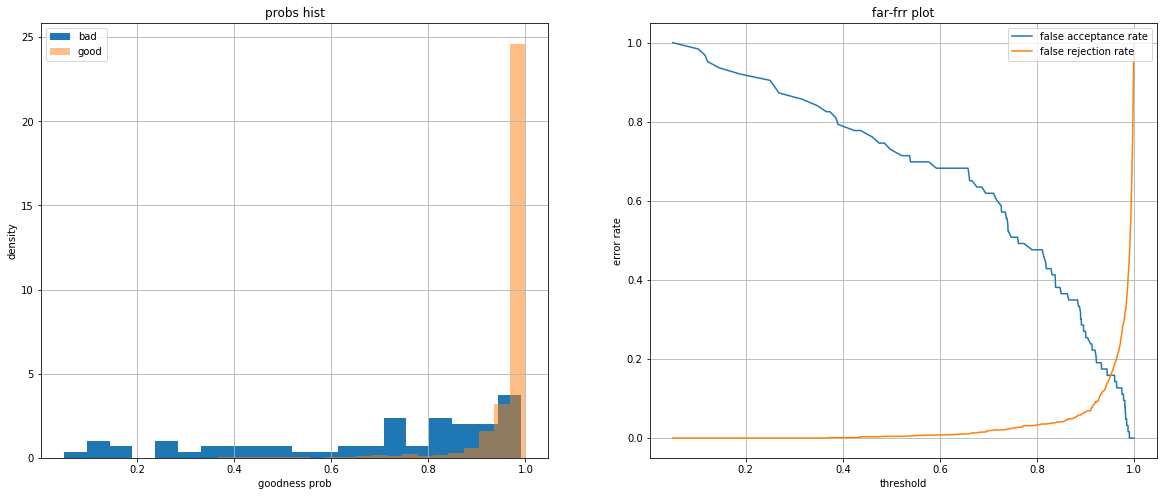

In [51]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)

tar=valid_prob_df[valid_prob_df['label'] == 1]['good']
imp=valid_prob_df[valid_prob_df['label'] == 0]['good']

ax.set_title("probs hist")
ax.hist(
    imp,
    density=True,
    bins=20
)
ax.hist(
    tar,
    density=True,
    alpha=0.5,
    bins=20
)
ax.grid(True)
ax.set_xlabel("goodness prob")
ax.set_ylabel("density")
ax.legend(["bad", "good"], loc=2)

thr, frr, far = compute_frr_far(
    tar=tar,
    imp=imp
)

ax2 = fig.add_subplot(122)

ax2.set_title("far-frr plot")
ax2.plot(thr, far)
ax2.plot(thr, frr)
ax2.grid(True)
ax2.set_xlabel("threshold")
ax2.set_ylabel("error rate")
ax2.legend(["false acceptance rate", "false rejection rate"], loc=1)

plt.show()